# Gather required libraries

In [17]:
import scipy
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Test data

In [5]:
# Given data (time and substrate concentration)

time_data = np.array([0, 1, 3, 10, 30, 60, 100])  # Time points
substrate_data = np.array([1, 0.8, 0.7, 0.5, 0.12, 0.02, 0])  # Substrate concentration over time
product_data1 = np.array([0, 0.20, 0.34, 0.44, 0.52, 0.57, 0.7])  # Concentration of product 1 over time
product_data2 = np.array([0, 0.08, 0.12, 0.17, 0.21, 0.27, 0.3])  # Concentration of product 2 over time

# Define functions

In [ ]:
# Define exponential decay function for substrate
def initial_dna_decay(t, k):
    return np.exp(-k * t)

# Define exponential growth function for products
def product_formation(t, k):
    return 1 - np.exp(-k * t)

In [12]:
# Define exponential decay function for substrate
def initial_dna_decay(t, k):
    return np.exp(-k * t)

# Define exponential growth function for products
def product_formation(t, k):
    return 1 - np.exp(-k * t)

# Fit exponential decay to substrate data
def fit_substrate(time_data, substrate_data):
    popt_S, _ = curve_fit(exponential_decay, time_data, substrate_data, p0=(0.1))
    return popt_S[0]

# Fit exponential growth to product data
def fit_product(time_data, product_data):
    popt_P, _ = curve_fit(exponential_growth, time_data, product_data, p0=(0.1), maxfev=6000)
    return popt_P[0]

# Perform independent fitting

In [13]:
# Fit substrate and products
k_depletion = fit_substrate(time_data, substrate_data)
k_formation1 = fit_product(time_data, product_data1)
k_formation2 = fit_product(time_data, product_data2)

# Determine the quality of the fit

In [14]:
def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Calculate R-squared for substrate and products
r_squared_substrate = r_squared(substrate_data, initial_dna_decay(time_data, k_depletion))
r_squared_product1 = r_squared(product_data1, product_formation(time_data, k_formation1))
r_squared_product2 = r_squared(product_data2, product_formation(time_data, k_formation2))

# Calculate sum of squared residuals for substrate and products
ssr_substrate = sum_squared_residuals(substrate_data, initial_dna_decay(time_data, k_depletion))
ssr_product1 = sum_squared_residuals(product_data1, product_formation(time_data, k_formation1))
ssr_product2 = sum_squared_residuals(product_data2, product_formation(time_data, k_formation2))

print("R-squared (Substrate):", r_squared_substrate)
print("R-squared (Product 1):", r_squared_product1)
print("R-squared (Product 2):", r_squared_product2)

print("Sum of Squared Residuals (Substrate):", ssr_substrate)
print("Sum of Squared Residuals (Product 1):", ssr_product1)
print("Sum of Squared Residuals (Product 2):", ssr_product2)


R-squared (Substrate): 0.9734104852797939
R-squared (Product 1): 0.3289846484305896
R-squared (Product 2): 0.3407321459935311
Sum of Squared Residuals (Substrate): 0.026224858518328984
Sum of Squared Residuals (Product 1): 0.22705242310390075
Sum of Squared Residuals (Product 2): 0.04467952427723841


# Plot the fits

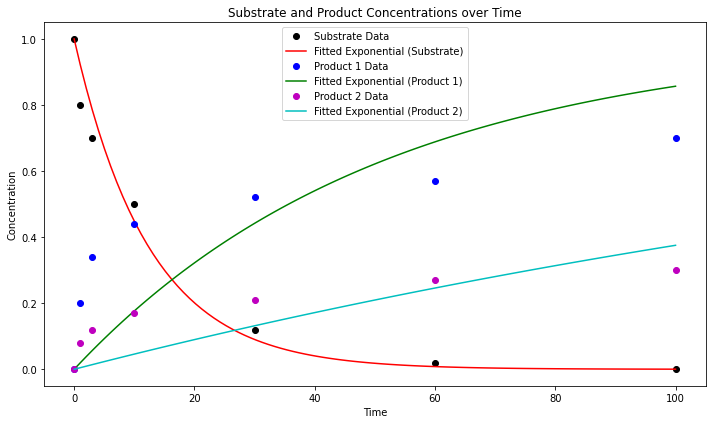

Depletion Rate (k_depletion): 0.08016459208473994
Formation Rate (k_formation1): 0.019432375384724157
Formation Rate (k_formation2): 0.0047044617381294


In [15]:
x_values = np.linspace(0, 100, 100)

# Plot the data and fitted exponential functions
plt.figure(figsize=(10, 6))

plt.plot(time_data, substrate_data, 'ko', label='Substrate Data')
plt.plot(x_values, initial_dna_decay(x_values, k_depletion), 'r-', label='Fitted Exponential (Substrate)')

plt.plot(time_data, product_data1, 'bo', label='Product 1 Data')
plt.plot(x_values, product_formation(x_values, k_formation1), 'g-', label='Fitted Exponential (Product 1)')

plt.plot(time_data, product_data2, 'mo', label='Product 2 Data')
plt.plot(x_values, product_formation(x_values, k_formation2), 'c-', label='Fitted Exponential (Product 2)')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Substrate and Product Concentrations over Time')
plt.legend()

plt.tight_layout()
plt.show()

print("Depletion Rate (k_depletion):", k_depletion)
print("Formation Rate (k_formation1):", k_formation1)
print("Formation Rate (k_formation2):", k_formation2)

# Fit decay rate to data based on differential equations

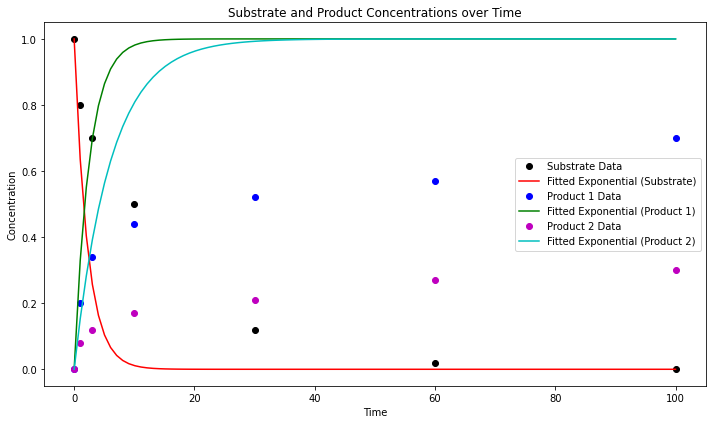

In [67]:
# Define the coupled ODE system for substrate depletion and product formation
def ode_system(t, y, k_depletion, k_formation1, k_formation2):
    S, P1, P2 = y
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S
    dP2dt = k_formation2 * S
    return [dSdt, dP1dt, dP2dt]

# Define the objective function for least squares minimization
def objective_function(params):
    k_depletion, k_formation1, k_formation2 = params
    y_predicted = ode_system(time_data, [substrate_data[0], 0, 0], k_depletion, k_formation1, k_formation2)
    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2))

# Initial guess for parameters
initial_guess = [0.1, 0.1, 0.1]

# Perform least squares minimization
result = least_squares(objective_function, initial_guess)

# Extract optimized parameters
k_depletion_opt, k_formation1_opt, k_formation2_opt = result.x

x_values = np.linspace(0, 100, 100)

# Plot the data and fitted exponential functions
plt.figure(figsize=(10, 6))

plt.plot(time_data, substrate_data, 'ko', label='Substrate Data')
plt.plot(x_values, initial_dna_decay(x_values, -k_depletion_opt), 'r-', label='Fitted Exponential (Substrate)')

plt.plot(time_data, product_data1, 'bo', label='Product 1 Data')
plt.plot(x_values, product_formation(x_values, k_formation1_opt), 'g-', label='Fitted Exponential (Product 1)')

plt.plot(time_data, product_data2, 'mo', label='Product 2 Data')
plt.plot(x_values, product_formation(x_values, k_formation2_opt), 'c-', label='Fitted Exponential (Product 2)')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Substrate and Product Concentrations over Time')
plt.legend()

plt.tight_layout()
plt.show()